In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
surfvel_data_40kms = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc")

In [3]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS'
simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(12, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1

log_c_slide_init = np.log10(13.5)*np.ones((JMAX+1, IMAX+1))

dict_og_state_fields_vals = {"xx_c_slide_init": log_c_slide_init}

dict_state_fields_num_dims = {"xx_c_slide_init": "2D"}

dict_state_coords = {"time_ad": time_ad,
               "zeta_c": exp_sigma_level,
               "y": yModel40,
               "x": xModel40}

dict_state_attrs_type = {"xx_c_slide_init": "nodiff"}

dict_state_fields_or_scalars = {"xx_c_slide_init": "field"}

dict_masks_observables = {"vs": None}

dict_prior_alphas = {"xx_c_slide_init": 1.0}
dict_prior_sigmas = {"xx_c_slide_init": None}
dict_prior_gammas = {"xx_c_slide_init": 10.0}
dict_prior_deltas = {"xx_c_slide_init": 0.1}

In [4]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

DA.l_bfgs(5, 3)

-------------------------------------
Initial fc = 3874738.08372731
-------------------------------------
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Step size alpha = 7.62939453125e-06
-------------------------------------
Iter 1, fc = 3185208.1177812684
-------------------------------------
Step size alpha = 1.0
-------------------------------------
Iter 2, fc = 2963602.0753220627
-------------------------------------
Step size alpha = 1.0
-------------------------------------
Iter 3, fc = 2815943.783196644
-------------------------------------
Step size alpha = 0.0625
-------

<xarray.Dataset> Size: 26kB
Dimensions:          (y: 73, x: 43)
Coordinates:
  * x                (x) float64 344B -7.2e+05 -6.8e+05 ... 9.2e+05 9.6e+05
  * y                (y) float64 584B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
Data variables:
    xx_c_slide_init  (y, x) float64 25kB ...
Attributes:
    history:  2025-02-04 16:49:59 -06:00 - Data produced

In [5]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

fc = DA.eval_cost()

sigma_B_squared, sigma_P_squared, delta_sigma_qoi_squared = DA.forward_uq_propagation(5, 5)

sigma_B_squared, sigma_P_squared, delta_sigma_qoi_squared

(7.376349794102176e+18, 5.425606187682513e+18, 0.264459205551694)

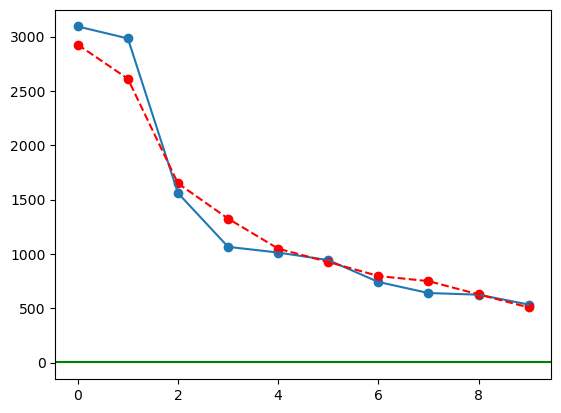

In [6]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

fc = DA.eval_cost()

U_misfit, Lambda_misfit = DA.revd(5, 5, mode = "misfit_prior_precond")
U_full, Lambda_full = DA.revd(5, 5, mode = "full_prior_precond")

plt.scatter(np.arange(Lambda_misfit.shape[0]), np.sort(Lambda_misfit)[::-1])
plt.plot(np.sort(Lambda_misfit)[::-1])

plt.scatter(np.arange(Lambda_full.shape[0]), np.sort(Lambda_full)[::-1], color = "red")
plt.plot(np.sort(Lambda_full)[::-1], "r--")

plt.axhline(1, color = "green")

In [7]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

fc = DA.eval_cost()

ds_x = DA.create_ad_tlm_action_input_nc(bool_randomize = True)
ds_x_tlm_only = DA.subset_of_ds(ds_x, "type", "tlm")
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(3263877.5340273418, 3263877.5340452944)

In [8]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

fc = DA.eval_cost()

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(3263877.5340273418, 3263877.5340452944)

In [9]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

fc = DA.eval_cost()

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

ds_Cx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_adj_action_or_tlm_action = "tlm_action")
ds_A_Cx = DA.eval_tlm_action()
ds_noise_cov_inv_A_Cx = DA.eval_noise_cov_inv_action(ds_A_Cx)

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)

ds_C_H_misfit_Cx = DA.eval_prior_preconditioned_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_C_H_misfit_Cx], ["tlm", "adj"]), DA.l2_inner_product([ds_A_Cx, ds_noise_cov_inv_A_Cx], ["tlmhessaction", "adjhessaction"])

(32510.07750932919, 32510.07750950808)

In [10]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_Cx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_adj_action_or_tlm_action = "tlm_action")
ds_C_inv_Cx = DA.eval_sqrt_prior_cov_inv_action()

DA.l2_inner_product([ds_C_inv_Cx, ds_C_inv_Cx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"])

(3059.5186882298813, 3059.5186882298804)

In [11]:
DA.l2_inner_product([ds_Cx, ds_Cx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"])

(30.447828106114777, 3059.5186882298804)

In [12]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

fc = DA.eval_cost()

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_C_H_Cx = DA.eval_prior_preconditioned_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_C_H_misfit_Cx], ["tlm", "adj"]), \
DA.l2_inner_product([ds_x_tlm_only, ds_C_H_misfit_Cx], ["tlm", "adj"]) + dict_prior_alphas["xx_c_slide_init"]*DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"]), \
DA.l2_inner_product([ds_x_tlm_only, ds_C_H_Cx], ["tlm", "adj"])

(32510.07750932919, 35569.59619755907, 35569.59619755907)

In [13]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

DA.gradient_descent(5, init_alpha = 1.0, min_alpha_tol = 1.e-10)

-------------------------------------
iter 0, fc = 3874738.08372731
-------------------------------------
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Step size alpha = 7.62939453125e-06
-------------------------------------
iter 1, fc = 3185208.1177812684
-------------------------------------
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed t

<xarray.Dataset> Size: 26kB
Dimensions:          (y: 73, x: 43)
Coordinates:
  * x                (x) float64 344B -7.2e+05 -6.8e+05 ... 9.2e+05 9.6e+05
  * y                (y) float64 584B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
Data variables:
    xx_c_slide_init  (y, x) float64 25kB 1.13 1.13 1.13 1.13 ... 1.13 1.13 1.13
Attributes:
    history:  2025-02-04 16:55:36 -06:00 - Data produced

In [14]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

DA.inexact_gn_hessian_cg(MAX_ITERS=5, init_alpha_gd = 1.e-6)

-------------------------------------
Initial fc = 3874738.08372731
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
CG iter 4
CG iter 5
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  113.12503763312729
Step size alpha = 0.25
-------------------------------------
Outer iter 1, fc = 3756016.2540346817
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
CG iter 4
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  142.88788915736419
Step size alpha = 1.0
-------------------------------------
Outer iter 2, fc = 3094567.961106768
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
CG iter 4
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  147.43532031377572
Step size alpha = 0.5
-------------------------------------
Outer iter 3, fc = 2742333.951885214
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
CG iter 4
conjugate_gradient: Convergence.

<xarray.Dataset> Size: 26kB
Dimensions:          (y: 73, x: 43)
Coordinates:
  * x                (x) float64 344B -7.2e+05 -6.8e+05 ... 9.2e+05 9.6e+05
  * y                (y) float64 584B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
Data variables:
    xx_c_slide_init  (y, x) float64 25kB ...
Attributes:
    history:  2025-02-04 16:57:51 -06:00 - Data produced

In [15]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

DA.inexact_gn_hessian_cg(MAX_ITERS=5, init_alpha_gd = 1.e-6, cg_tolerance_type = "linear")

-------------------------------------
Initial fc = 3874738.08372731
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
CG iter 4
CG iter 5
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  113.12503763312729
Step size alpha = 0.25
-------------------------------------
Outer iter 1, fc = 3756016.2540346817
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
CG iter 4
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  142.88788915736419
Step size alpha = 1.0
-------------------------------------
Outer iter 2, fc = 3094567.961106768
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
CG iter 4
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  147.43532031377572
Step size alpha = 0.5
-------------------------------------
Outer iter 3, fc = 2742333.951885214
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
CG iter 4
conjugate_gradient: Convergence.

<xarray.Dataset> Size: 26kB
Dimensions:          (y: 73, x: 43)
Coordinates:
  * x                (x) float64 344B -7.2e+05 -6.8e+05 ... 9.2e+05 9.6e+05
  * y                (y) float64 584B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
Data variables:
    xx_c_slide_init  (y, x) float64 25kB ...
Attributes:
    history:  2025-02-04 16:59:50 -06:00 - Data produced